In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = 'D:/Disease Prediction 2'

In [4]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria


  0%|          | 0.00/675M [00:00<?, ?B/s]
  0%|          | 1.00M/675M [00:01<12:49, 919kB/s]
  0%|          | 2.00M/675M [00:01<06:30, 1.81MB/s]
  0%|          | 3.00M/675M [00:01<04:16, 2.75MB/s]
  1%|          | 5.00M/675M [00:01<02:10, 5.37MB/s]
  1%|          | 7.00M/675M [00:01<01:30, 7.72MB/s]
  1%|▏         | 9.00M/675M [00:01<01:11, 9.80MB/s]
  2%|▏         | 11.0M/675M [00:01<00:59, 11.6MB/s]
  2%|▏         | 13.0M/675M [00:02<00:52, 13.1MB/s]
  2%|▏         | 15.0M/675M [00:02<00:48, 14.2MB/s]
  3%|▎         | 17.0M/675M [00:02<00:54, 12.7MB/s]
  3%|▎         | 19.0M/675M [00:02<01:10, 9.82MB/s]
  3%|▎         | 21.0M/675M [00:03<01:22, 8.29MB/s]
  3%|▎         | 22.0M/675M [00:03<01:29, 7.65MB/s]
  3%|▎         | 23.0M/675M [00:03<01:31, 7.52MB/s]
  4%|▎         | 24.0M/675M [00:03<01:36, 7.11MB/s]
  4%|▎         | 25.0M/675M [00:03<01:41, 6.74MB/s]
  4%|▍         | 26.0M/675M [00:03<01:44, 6.50MB/s]
  4%|▍         | 27.0M/675M [00:04<01:55, 5.88MB/s]
  4%|▍         | 28.0

In [5]:
import zipfile

z= zipfile.ZipFile('cell-images-for-detecting-malaria.zip')
z.extractall()

In [6]:
import os, shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

2.16.1


In [7]:
original_dataset_parasitized = os.path.join('cell_images/cell_images', 'Parasitized/')
original_dataset_uninfected = os.path.join('cell_images/cell_images', 'Uninfected/')

In [8]:
# Create a base dir
if not os.path.isdir('healthy_and_infected'):
    base_dir = 'healthy_and_infected'
    os.mkdir(base_dir)

In [9]:
# Make train, valid and test directories
#train
if not os.path.isdir('healthy_and_infected/train'):
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
#valid
if not os.path.isdir('healthy_and_infected/valid'):
    valid_dir = os.path.join(base_dir, 'valid')
    os.mkdir(valid_dir)
#test
if not os.path.isdir('healthy_and_infected/test'):
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

In [10]:
# Make directories for infected images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/inf'):
    infected_trn_dir = os.path.join(train_dir, 'inf')
    os.mkdir(infected_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/inf'):
    infected_valid_dir = os.path.join(valid_dir, 'inf')
    os.mkdir(infected_valid_dir)

if not os.path.isdir('healthy_and_infected/test/inf'):
    infected_test_dir = os.path.join(test_dir, 'inf')
    os.mkdir(infected_test_dir)

In [11]:
# Make directories for healthy images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/healthy'):
    healthy_trn_dir = os.path.join(train_dir, 'healthy')
    os.mkdir(healthy_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/healthy'):
    healthy_valid_dir = os.path.join(valid_dir, 'healthy')
    os.mkdir(healthy_valid_dir)

if not os.path.isdir('healthy_and_infected/test/healthy'):
    healthy_test_dir = os.path.join(test_dir, 'healthy')
    os.mkdir(healthy_test_dir)

In [12]:
files1 = os.listdir('cell_images/cell_images/Parasitized/')
fnames1 = []
for i in range(13779):
    fnames1.append(files1[i])

if 'Thumbs.db' in fnames1:
    os.remove('cell_images/cell_images/Parasitized/Thumbs.db')

files2 = os.listdir('cell_images/cell_images/Uninfected/')
fnames2 = []
for i in range(13779):
    fnames2.append(files2[i])

if 'Thumbs.db' in fnames2:
    os.remove('cell_images/cell_images/Uninfected/Thumbs.db')

In [13]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(11023):
    fnames.append(files[i])
  
for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_trn_dir, fname)
    shutil.copyfile(src,dst)

In [14]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(11023, 12401):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src,dst)

In [15]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(12401, 13779):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src,dst)

In [16]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(11023):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_trn_dir, fname)
    shutil.copyfile(src,dst)

In [17]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(11023, 12401):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src,dst)

In [18]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(12401, 13779):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src,dst)

In [19]:
print("{} Infected training images:".format(len(os.listdir(infected_trn_dir))))
print("{} Uninfected training images:".format(len(os.listdir(healthy_trn_dir))))
print(" {} Infected valid images:".format(len(os.listdir(infected_valid_dir))))
print(" {} Uninfected valid images:".format(len(os.listdir(healthy_valid_dir))))
print(" {} Infected testing images:".format(len(os.listdir(infected_test_dir))))
print(" {} Uninfected testing images:".format(len(os.listdir(healthy_test_dir))))

11023 Infected training images:
11023 Uninfected training images:
 1378 Infected valid images:
 1378 Uninfected valid images:
 1378 Infected testing images:
 1378 Uninfected testing images:


# Exploratory Data Analysis

In [20]:
# Train
infected_trn_fpaths = [os.path.join(infected_trn_dir, fpath) for fpath in os.listdir(infected_trn_dir)]
healthy_trn_fpaths = [os.path.join(healthy_trn_dir, fpath) for fpath in os.listdir(healthy_trn_dir)]

# Valid
infected_valid_fpaths = [os.path.join(infected_valid_dir, fpath) for fpath in os.listdir(infected_valid_dir)]
healthy_valid_fpaths = [os.path.join(healthy_valid_dir, fpath) for fpath in os.listdir(healthy_valid_dir)]

# Test
infected_test_fpaths = [os.path.join(infected_test_dir, fpath) for fpath in os.listdir(infected_test_dir)]
healthy_test_fpaths = [os.path.join(healthy_test_dir, fpath) for fpath in os.listdir(healthy_test_dir)]

In [21]:
def get_img_shape(idx, img, total_num_images):
    
    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 2000
working on img 4000
working on img 6000
working on img 8000
working on img 10000
working on img 12000
working on img 14000
working on img 16000
working on img 18000
working on img 20000
working on img 22000
working on img 22045


In [22]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [40 46  3]
Avg Dimensions:           [132.07520639 131.60382836   3.        ]
Median Dimensions:        [130. 130.   3.]
Most Frequent Dimensions: [130 130   3]
Max Dimensions:           [346 265   3]


In [23]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

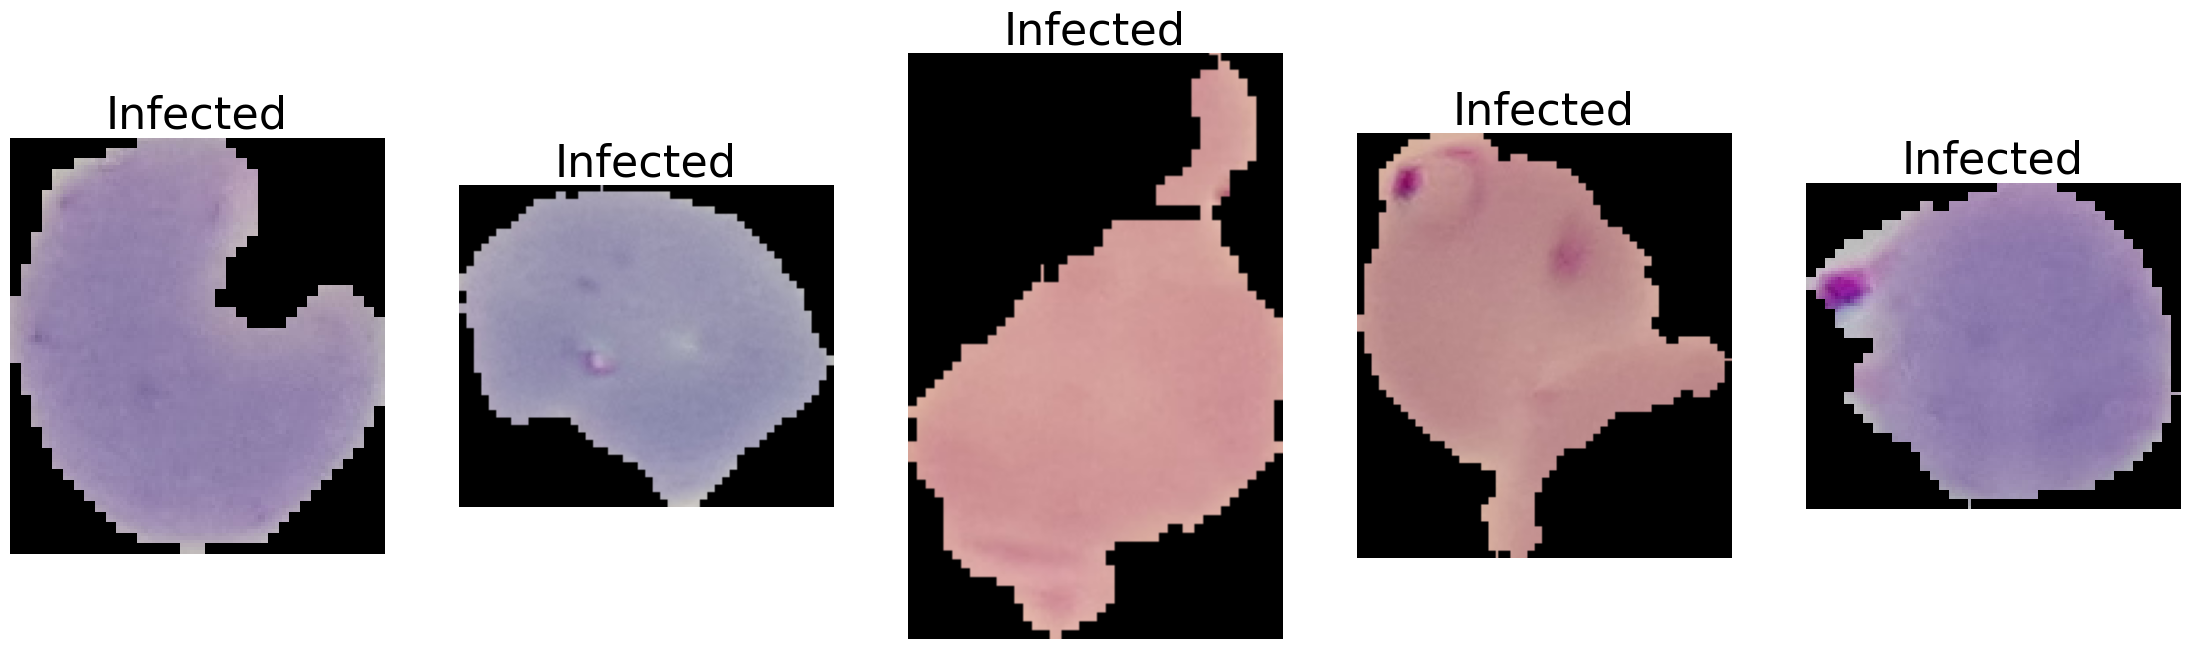

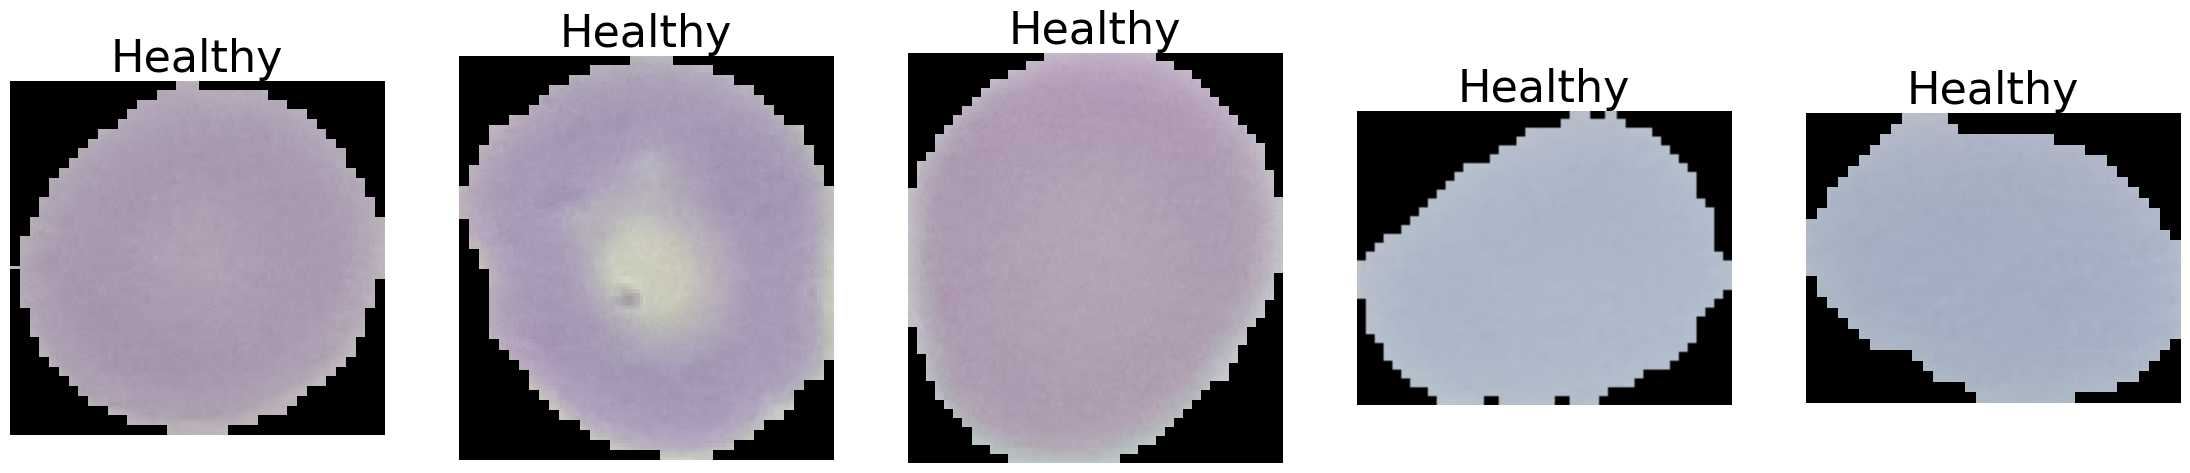

In [25]:
fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(infected_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Infected', fontsize=32)
plt.show()


fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(healthy_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Healthy', fontsize=32)
#plt.savefig("outputs/malaria_cell_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

# Data augmentation and resizing images

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [27]:
class_labels, class_names

({'healthy': 0, 'inf': 1}, {0: 'healthy', 1: 'inf'})

# Transfer Learning - VGG19 CNN Architecture

In [32]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)



sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Call backs
filepath = 'Model/malaria.keras'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = SGD(learning_rate=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

In [34]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=100,
                          epochs=25,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7320 - loss: 0.5400
Epoch 1: val_loss improved from inf to 0.27319, saving model to Model/malaria.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 483s 5s/step - accuracy: 0.7325 - loss: 0.5393 - val_accuracy: 0.8984 - val_loss: 0.2732 - learning_rate: 1.0000e-04
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8563 - loss: 0.3353
Epoch 2: val_loss improved from 0.27319 to 0.19223, saving model to Model/malaria.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 478s 5s/step - accuracy: 0.8564 - loss: 0.3353 - val_accuracy: 0.9438 - val_loss: 0.1922 - learning_rate: 1.0000e-04
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8765 - loss: 0.3197
Epoch 3: val_loss improved from 0.19223 to 0.18261, saving model to Model/malaria.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 477s 5s/step - accuracy: 0.8764 - loss: 0.3196 - val_accuracy: 0.9401 - val_loss: 0.1826 - learning_rate: 1.0000e-04
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/s

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 7: val_loss improved from 0.16659 to 0.16548, saving model to Model/malaria.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.8833 - loss: 0.3008 - val_accuracy: 0.9419 - val_loss: 0.1655 - learning_rate: 1.0000e-04
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8932 - loss: 0.2836
Epoch 8: val_loss did not improve from 0.16548
100/100 ━━━━━━━━━━━━━━━━━━━━ 468s 5s/step - accuracy: 0.8932 - loss: 0.2835 - val_accuracy: 0.9430 - val_loss: 0.1888 - learning_rate: 1.0000e-04
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8857 - loss: 0.2772
Epoch 9: val_loss improved from 0.16548 to 0.15529, saving model to Model/malaria.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.8858 - loss: 0.2771 - val_accuracy: 0.9456 - val_loss: 0.1553 - learning_rate: 1.0000e-04
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9085 - loss: 0.2586
Epoch 10: val_loss did not improve from 0.15529
100/100 ━━━━━━━━━━━━━━━━━━━━ 472s 

In [35]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg19_model_01malaria.weights.h5', overwrite=True)

In [36]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 2756 images belonging to 2 classes.


In [37]:
# Load the saved model
model_03.load_weights('model_weights/vgg19_model_01malaria.weights.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_03.evaluate(valid_generator)
vgg_test_eval_01 = model_03.evaluate(test_generator)

print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))

87/87 ━━━━━━━━━━━━━━━━━━━━ 85s 967ms/step - accuracy: 0.9471 - loss: 0.1473
   1/2756 ━━━━━━━━━━━━━━━━━━━━ 5:57 130ms/step - accuracy: 1.0000 - loss: 0.0179

C:\Users\lloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 244s 88ms/step - accuracy: 0.9661 - loss: 0.1363
Validation loss:     0.1412
Validation accuracy: 0.9496
Test loss:           0.1109
Test accuracy:       0.9692


In [38]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 239s 87ms/step


In [39]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['healthy', 'infected']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['healthy', 'infected'], 
                        columns=['healthy', 'infected'])

              precision    recall  f1-score   support

     healthy       0.97      0.97      0.97      1378
    infected       0.97      0.97      0.97      1378

    accuracy                           0.97      2756
   macro avg       0.97      0.97      0.97      2756
weighted avg       0.97      0.97      0.97      2756



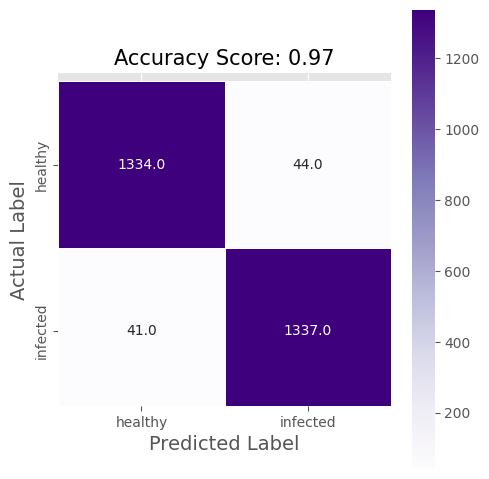

In [40]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

## Prediction results for 4 randomly selected images

In [56]:
test_images = [img for img in random.sample(infected_test_fpaths, 2)]
test_images.extend([img for img in random.sample(healthy_test_fpaths, 2)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


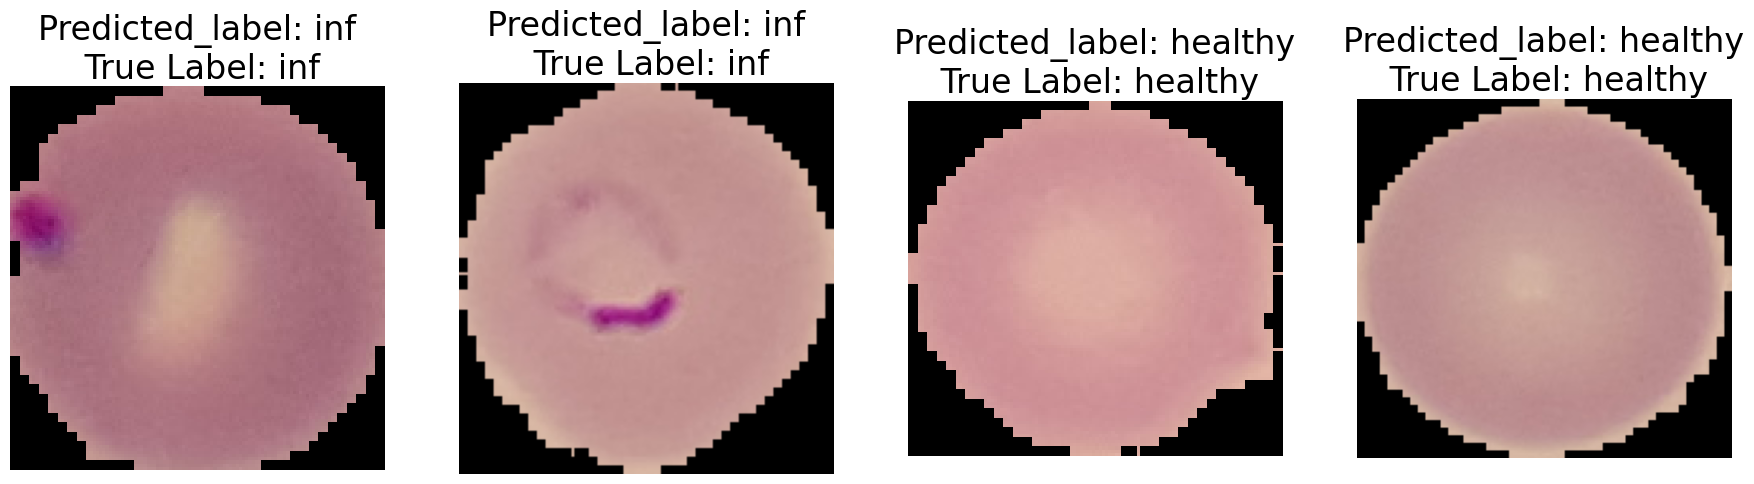

In [57]:
true_labels = []
predicted_labels = []
fig = plt.figure(figsize=(28, 14))
columns = 5
rows = 2

for i in range(len(test_images)):  # Iterate over the actual length of test_images
    if i < columns * rows:  # Limit the loop to the desired number of subplots
        fig.add_subplot(rows, columns, i+1)  # Adjust the subplot index to start from 1
        true_label = true_labels.append(test_images[i].split('\\')[2])  # Adjust split based on the path format
        img = mpimg.imread(test_images[i])
        plt.imshow(img)
        plt.axis('off')
        img = tf.keras.utils.load_img(test_images[i], target_size=(128, 128))
        img = tf.keras.utils.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        prediction = model_03.predict(img)
        predicted_label = np.argmax(prediction)
        plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], true_labels[i]), fontsize=24)

plt.show()


SyntaxError: incomplete input (905239267.py, line 7)